---
### Polygon sampling based on the Jaccard Distance
---


In [1]:
from watermark import watermark
print(watermark(author="\033[1m" +"Tiago F. R. Ribeiro" + "\033[0m", 
                github_username="\033[1m" +"Tiago1Ribeiro"+ "\033[0m", 
                current_date=True, current_time=True, python=True, updated=True,
                iversions=True,  globals_= globals()))

Author: Tiago F. R. Ribeiro

Github username: Tiago1Ribeiro

Last updated: 2023-04-03 12:14:44

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0



In [5]:
import os
from glob import glob
from shapely.wkt import loads

#### Data Sources

In [139]:
SEGS_POL_FILE = "E://BurnedAreaUAV_files//Results//WKT_files//segs_unet_base.wkt"
SEGS_TRAIN_FILE = "E://BurnedAreaUAV_files//BurnedAreaUAV_dataset//WKT_files//train_valid.wkt"
SAMPLED_SEGS = "E://BurnedAreaUAV_files//Interpolation//reference_masks//sampled_masks.wkt"
# read wkt file
with open(SEGS_TRAIN_FILE, 'r') as wkt_file:
    # list of polygons
    multipolygons = wkt_file.readlines()
# convert multipolygons to shapely polygons
sh_polygons = list()
for multipolygon in multipolygons:
    sh_polygon = loads(multipolygon)
    sh_polygons.append(sh_polygon)

### Functions

#### calculate_distances

In [9]:
from scipy.spatial.distance import jaccard
import numpy as np
from tqdm import tqdm
from rasterio.features import rasterize

def calculate_distances(polygons, out_shape = (720, 1280)):
    """
    Calculates the Jaccard distance between binary segmentation masks of the 
    first and subsequent polygons

    Args:
        polygons (list): A list of polygons represented as a list of coordinate 
        tuples.
        out_shape (tuple): The shape of the output rasterized mask. 
        Default is (720, 1280).

    Returns:
        dict: A dictionary with two keys - "Jaccard distance". The values
        for each key are lists containing the distance values between the 
        first and subsequent polygons

    """
    distances = {"Jaccard distance":[]}
    mask_t0 = rasterize([polygons[0]], out_shape)
    coord_t0 = np.argwhere(mask_t0)

    # Convert each polygon to a binary mask and calculate distances
    for i in range(len(polygons)-1):
        mask_tn = rasterize([polygons[i+1]], out_shape)
        jaccard_distance = jaccard(mask_t0.flatten(), mask_tn.flatten())
        distances["Jaccard distance"].append(jaccard_distance)
        print(f"{i+1}/{len(polygons)}: Jaccard distance: {jaccard_distance:.4f} ", end="\r")
    return distances

#### plot_polygons_as_images

In [118]:
def plot_polygons_as_images(distances, polygons, image_size=(720, 1280)):
    # counts number of polygons
    num_polygons = len(distances['index'])
    # print('num_polygons:', num_polygons)
    # calculate number of rows and columns in the grid
    num_cols = 4
    num_rows = int(np.ceil(num_polygons / num_cols))
    # print('num. of graphs:', num_rows*num_cols)
    
    # create a new figure with the desired size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, num_rows*4))
    axes = axes.flatten()  
    
    # loop over the polygons and plot them as images on the grid
    i = 0
    for idx in distances['index']:
        ax = axes[i]
        img = rasterio.features.rasterize([polygons[idx]], out_shape=image_size)
        ax.imshow(img)
        ax.set_title(f"Frame #{idx}")
        i += 1
    
    # adjust the layout to make sure all images are visible
    fig.tight_layout()
    
    # show the plot
    plt.show()

#### sample_polygons

In [279]:
# def sample_polygons(polygons, distances, threshold=0.05):
#     # list of distances
#     dist_list = distances['Jaccard distance']
#     # add index to each distance
#     dist_list = [(i, dist) for i, dist in enumerate(dist_list)]
#     # sort list by distance
#     dist_list.sort(key=lambda x: x[1])
#     # calculate max distance
#     max_dist = dist_list[-1][1]
#     # calculate threshold according to number of samples
#     threshold = max_dist / num_samples
#     print(f"num_samples: {num_samples}") 
#     print(f"Threshold: {threshold:.4f}")
    
#     # filter list to polygons whose distance from the first polygon is >= threshold
#     filtered_list = [(i, dist) for i, dist in dist_list if dist >= threshold]
#     # calculate quotient of filtered list length and number of desired samples
#     n = len(filtered_list) // num_samples
    
#     # extract samples from filtered list
#     samples = []
#     idx = 0
#     distances = {"index": [0], "Jaccard distance":[0.0]}


#     while idx < len(polygons)-1:
#         mask_n = rasterize([polygons[idx]], out_shape)
#         while jaccard_distance < threshold:
#             idx += 1
#             mask_m = rasterize([polygons[idx]], out_shape)
#             jaccard_distance = jaccard(mask_n.flatten(), mask_m.flatten())

#         distances["index"].append(idx)
#         distances["Jaccard distance"].append(jaccard_distance)

#         print(f"index: {idx}, Jaccard distance: {jaccard_distance}")

        

#         # select every n-th polygon from filtered list
#         index = i * n
#         samples.append(filtered_list[index][0])
    
#     # get the actual polygons corresponding to the sampled indices
#     sampled_polygons = [polygons[i] for i in samples]
#     # number of samples
#     print(f"Number of samples: {len(samples)}")
    
#     return [(i, p) for i, p in zip(samples, sampled_polygons)]

In [37]:
def sample_polygons_v2(polygons, threshold=0.15, out_shape = (720, 1280)):
    """
    Generate a set of samples from a list of polygons based on their similarity.

    Args:
        polygons (list): A list of polygons represented as lists of (x, y) tuples.
        threshold (float): The Jaccard distance threshold for creating a new sample.
            Defaults to 0.15.
        out_shape (tuple): The output shape of the rasterized polygons.
            Defaults to (720, 1280).

    Returns:
        dict: A dictionary with two keys: "index" and "Jaccard distance".
            The "index" value is the index of the polygon in the input list 
            for each sample.
            The "Jaccard distance" value is the Jaccard distance between the 
            sample and the previous one.

    """
    # instantiate dictionary to store index and distance values
    samples = {"index": [0], "Jaccard distance":[0.0]}
    jaccard_distance = 0.0
    idx = 0
    while idx < len(polygons)-1:
        mask_n = rasterize([polygons[idx]], out_shape)
        jaccard_distance = 0.0
        while jaccard_distance < threshold and idx < len(polygons)-1:
            idx += 1
            mask_m = rasterize([polygons[idx]], out_shape)
            jaccard_distance = jaccard(mask_n.flatten(), mask_m.flatten())
            
        # append index and distance to dictionary
        samples["index"].append(idx)
        samples["Jaccard distance"].append(jaccard_distance)
        print(f"index: {idx}, Jaccard distance: {jaccard_distance:.4f}")
    print(f"Number of resulting samples: {len(samples['index'])}")

    return samples

In [129]:
threshold = 0.15
samples = sample_polygons_v2(sh_polygons, threshold=threshold)

index: 19, Jaccard distance: 0.1590
index: 28, Jaccard distance: 0.1528
index: 48, Jaccard distance: 0.1830
index: 56, Jaccard distance: 0.1570
index: 74, Jaccard distance: 0.1745
index: 82, Jaccard distance: 0.1522
index: 87, Jaccard distance: 0.1598
index: 106, Jaccard distance: 0.1684
index: 128, Jaccard distance: 0.1717
index: 173, Jaccard distance: 0.1501
index: 195, Jaccard distance: 0.1529
index: 225, Jaccard distance: 0.1120
Number of resulting samples: 13


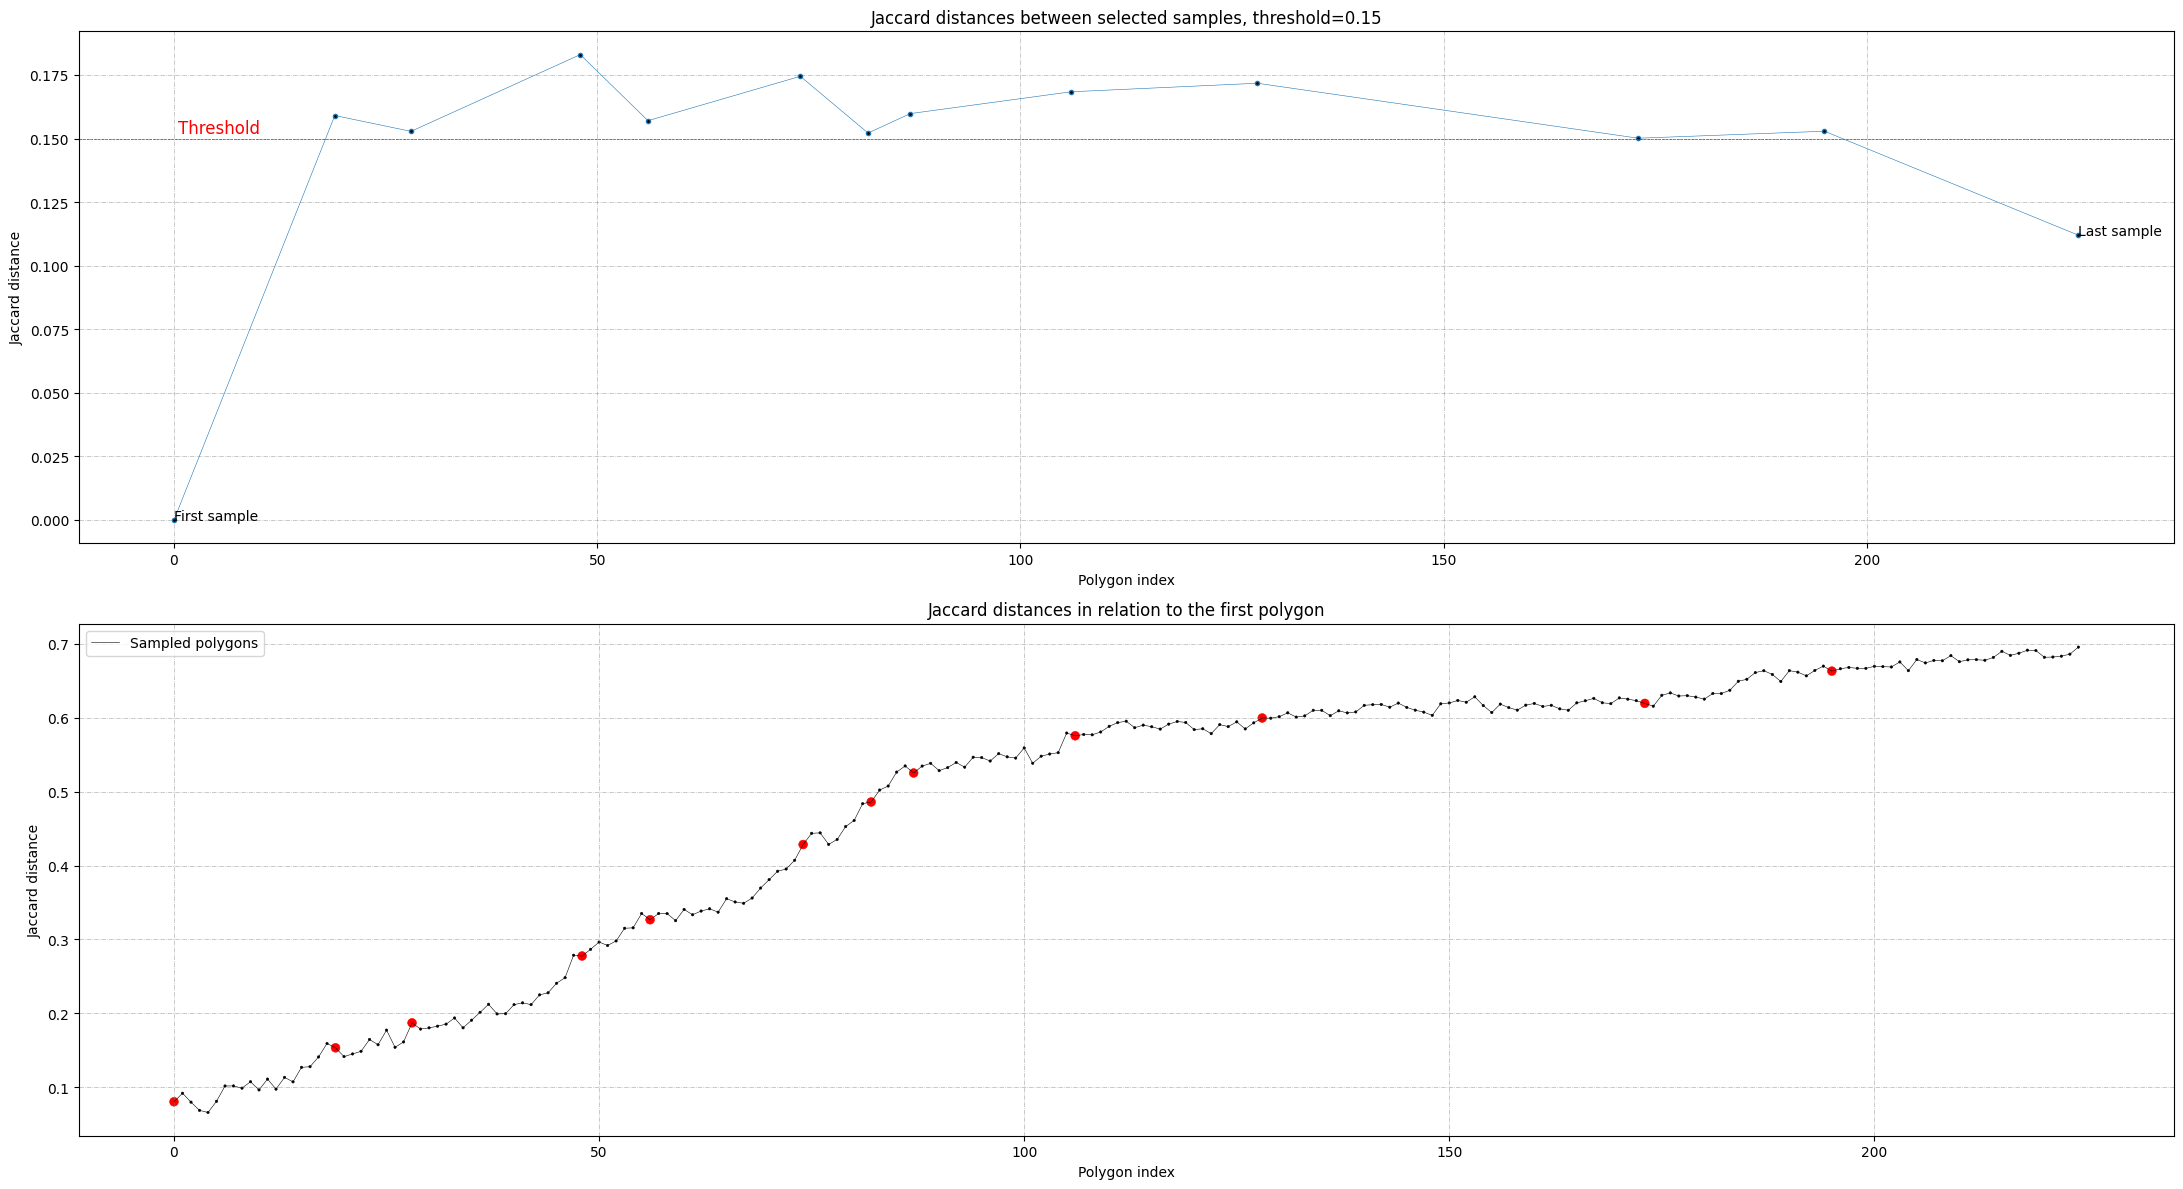

In [149]:
import matplotlib.pyplot as plt

# create two subplots side by side
fig, axs = plt.subplots(2, 1, figsize=(22, 12))

# plot the distances for the first subplot
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)
axs[0].plot(samples["index"], samples["Jaccard distance"], marker='o', markersize=3,
            markerfacecolor='black', linewidth=0.4)
axs[0].set_xlabel("Polygon index")
axs[0].set_ylabel("Jaccard distance")
axs[0].set_title("Jaccard distances between selected samples, threshold=0.15")
# add a threshold line with a label
axs[0].axhline(y=threshold, color='r', linestyle='--', linewidth=0.5)
axs[0].text(0.5, threshold+0.002, "Threshold", color='r', fontsize=12)
# add a text annotation to the first and last sample
axs[0].annotate("First sample", xy=(0, 0), xytext=(0, 0.0), fontsize=10)
axs[0].annotate("Last sample", xy=(samples["index"][-1], 0), 
                xytext=(samples["index"][-1], samples["Jaccard distance"][-1]), 
                fontsize=10)

# plot the distances for the second subplot
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.6)
axs[1].plot(range(len(distances["Jaccard distance"])), distances["Jaccard distance"],
            c='black', linewidth=0.4)  
axs[1].scatter(range(len(distances["Jaccard distance"])), 
               distances["Jaccard distance"],
               s=[40 if i in samples["index"]  else 3 for i in range(len(distances["Jaccard distance"]))],
               c=["red" if i in samples["index"] else 'black' for i in range(len(distances["Jaccard distance"]))],
               marker='o', facecolor='black', linewidth=0.4)
# plot line plot to connect the dots
axs[1].set_xlabel("Polygon index")
axs[1].set_ylabel("Jaccard distance")
axs[1].set_title("Jaccard distances in relation to the first polygon")
axs[1].legend(["Sampled polygons"])

plt.tight_layout()

plt.show()

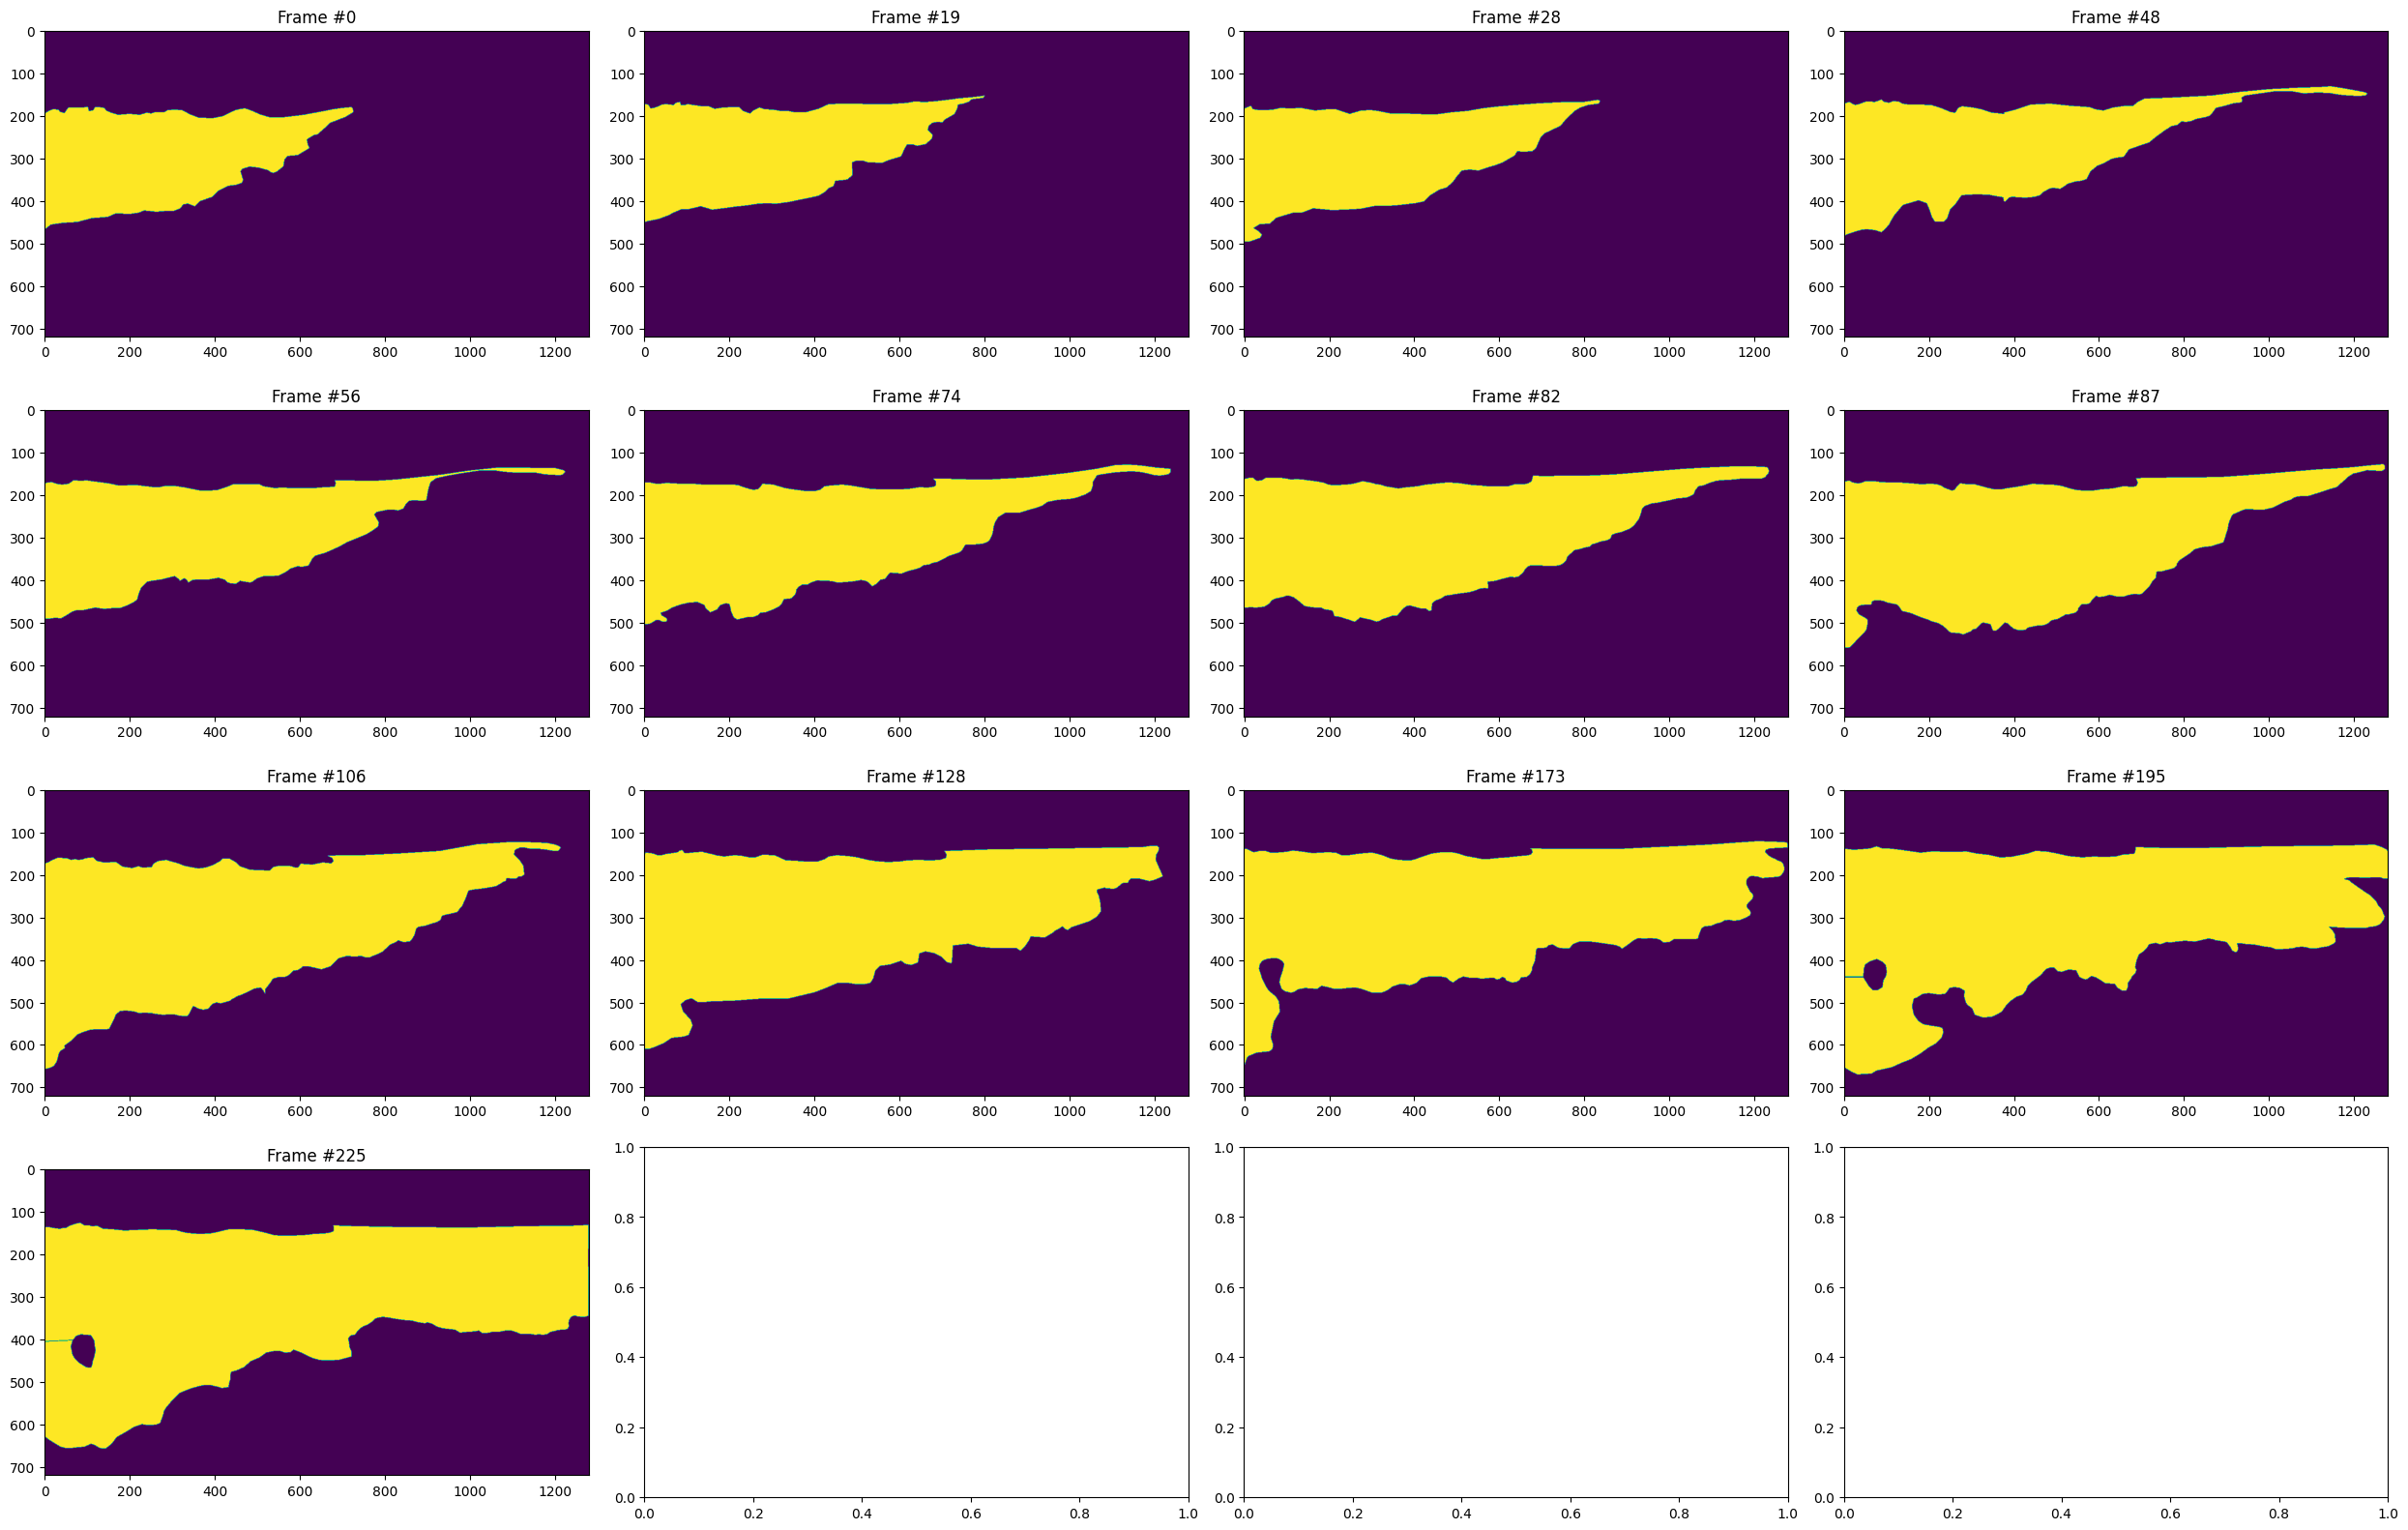

In [131]:
import rasterio
plot_polygons_as_images(distances=samples, polygons=sh_polygons)

In [141]:
# save the sampled polygons to a wkt file
for i in samples["index"]:
    with open(SAMPLED_SEGS, "a") as f:
        f.write(sh_polygons[i].wkt + "\n")

In [347]:
from sklearn.cluster import DBSCAN

def sample_polygons_v3(polygons, threshold=0.15, out_shape=(720, 1280), eps=0.5, min_samples=3):
    

    # instantiate dictionary to store index and distance values
    distances = {"index": [0], "Jaccard distance":[0.0]}
    jaccard_distance = 0.0
    idx = 0
    while idx < len(polygons)-1:
        mask_n = rasterize([polygons[idx]], out_shape)
        jaccard_distance = 0.0
        while jaccard_distance < threshold and idx < len(polygons)-1:
            idx += 1
            mask_m = rasterize([polygons[idx]], out_shape)
            jaccard_distance = jaccard(mask_n.flatten(), mask_m.flatten())
        # append index and distance to dictionary
        distances["index"].append(idx)
        distances["Jaccard distance"].append(jaccard_distance)
        print(f"index: {idx}, Jaccard distance: {jaccard_distance:.4f}")
    print(f"Number of resulting samples: {len(distances['index'])}")
    return distances

In [8]:
import numpy as np
from scipy.spatial.distance import jaccard
# define function to calculate Jaccard distance
# def jaccard(a, b):
#     intersection = np.logical_and(a, b)
#     union = np.logical_or(a, b)
#     return intersection.sum() / union.sum()

# define function to filter polygons using DBSCAN
def filter_polygons(polygons, eps=0.3, min_samples=3, out_shape = (720, 1280)):

    num_polygons = len(polygons)
    # calculate pairwise Jaccard distance between masks
    dist_matrix = np.zeros((num_polygons,num_polygons))
    for i in range(num_polygons):
        mask_i = rasterize([polygons[i]], out_shape)
        print(f"mask {i} rasterized")
        for j in range(i, num_polygons):
            mask_j = rasterize([polygons[j]], out_shape)
            dist_matrix[i, j] = jaccard(mask_i.flatten(), mask_j.flatten())
            dist_matrix[j, i] = dist_matrix[i, j]
    
    # cluster masks using DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(dist_matrix)
    # filter out polygons with label -1 (outliers)
    filtered_polygons = [polygon for i, polygon in enumerate(polygons) if labels[i] != -1]
    return filtered_polygons, dist_matrix

In [ ]:
filtered, dist_matrix = filter_polygons(polygons, eps=0.3, min_samples=3, out_shape = (720, 1280))

In [429]:
from multiprocessing import Pool
def calc_jaccard(polygons, i, j):
    intersection = polygons[i].intersection(polygons[j]).area
    union = polygons[i].union(polygons[j]).area
    jaccard_dist = 1 - (intersection/union)

# calculate pairwise Jaccard distance between masks
with Pool() as p:
    dist_matrix = np.array(p.starmap(calc_jaccard, [(i, j) for i in range(num_polygons) for j in range(i, num_polygons)]))

dist_matrix = dist_matrix + dist_matrix.T - np.diag(dist_matrix.diagonal())

In [ ]:
num_polygons = len(polygons)
# calculate pairwise Jaccard distance between masks
dist_matrix = np.zeros((num_polygons,num_polygons))

for i in range(num_polygons):
    print(f"mask {i} processed")
    for j in range(i, num_polygons):
        intersection = polygons[i].intersection(polygons[j]).area
        union = polygons[i].union(polygons[j]).area
        jaccard_dist = 1 - (intersection/union)
        dist_matrix[i, j] = jaccard_dist
        dist_matrix[j, i] = dist_matrix[i, j]

# cluster masks using DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
labels = db.fit_predict(dist_matrix)
# filter out polygons with label -1 (outliers)
filtered_polygons = [polygon for i, polygon in enumerate(polygons) if labels[i] != -1]


In [ ]:
# https://scikit-learn.org/stable/modules/outlier_detection.html

# https://neptune.ai/blog/anomaly-detection-in-time-series


In [409]:
from shapely.geometry import Polygon

def filter_polygons(polygons, eps=0.3, min_samples=3, out_shape=(720, 1280)):
    num_polygons = len(polygons)
    dist_matrix = np.zeros((num_polygons, num_polygons))
    
    # calculate pairwise Jaccard distance between masks
    for i in range(num_polygons):
        print(f"Calculating distances for mask {i+1} of {num_polygons}", end='\r')
        mask_i = polygons[i].simplify(1e-8, preserve_topology=False).buffer(0).exterior.coords[:]
        polygon_i = Polygon(mask_i)
        for j in range(i, num_polygons):
            mask_j = polygons[j].simplify(1e-8, preserve_topology=False).buffer(0).exterior.coords[:]
            polygon_j = Polygon(mask_j)
            dist_matrix[i, j] = 1 - polygon_i.intersection(polygon_j).area / polygon_i.union(polygon_j).area
            dist_matrix[j, i] = dist_matrix[i, j]
    
    # cluster masks using DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    labels = db.fit_predict(dist_matrix)
    
    # filter out polygons with label -1 (outliers)
    filtered_polygons = [polygon for i, polygon in enumerate(polygons) if labels[i] != -1]
    
    return filtered_polygons


In [ ]:
filter_polygons(polygons, eps=0.3, min_samples=3, out_shape=(720, 1280))

#### plot_polygons_as_images

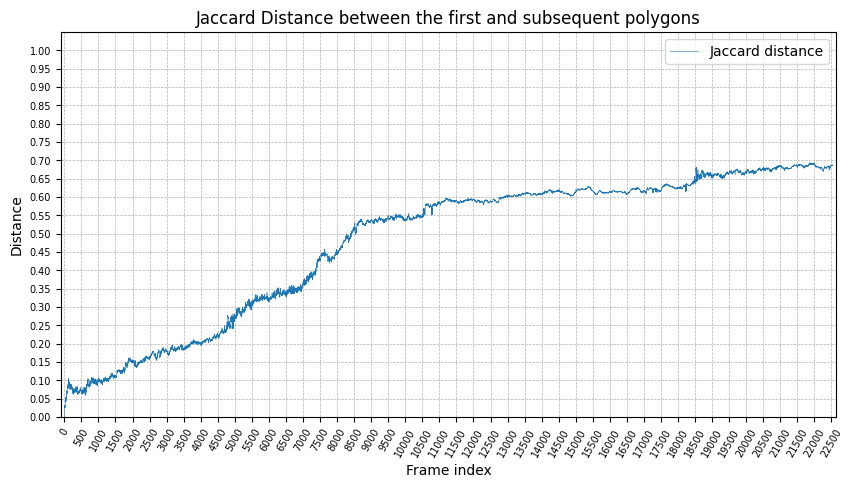

In [310]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams['lines.linewidth'] = 0.4
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.grid(True,  linestyle='--', linewidth=0.5)
plt.ylim(0, 1.05)
plt.xlim(0-100, len(polygons)+100)
plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, len(polygons)-1, 500))
plt.xticks(rotation=60)

jaccard_dist = distances["Jaccard distance"]
frame_indices = range(len(polygons)-1)

plt.plot(frame_indices, jaccard_dist, label="Jaccard distance")
plt.xlabel("Frame index")
plt.ylabel("Distance")
plt.title("Jaccard Distance between the first and subsequent polygons")
plt.legend()
plt.show()

20
num_samples: 20
Threshold: 0.0347
Number of samples: 20
num_polygons: 20
num_graficas: 21


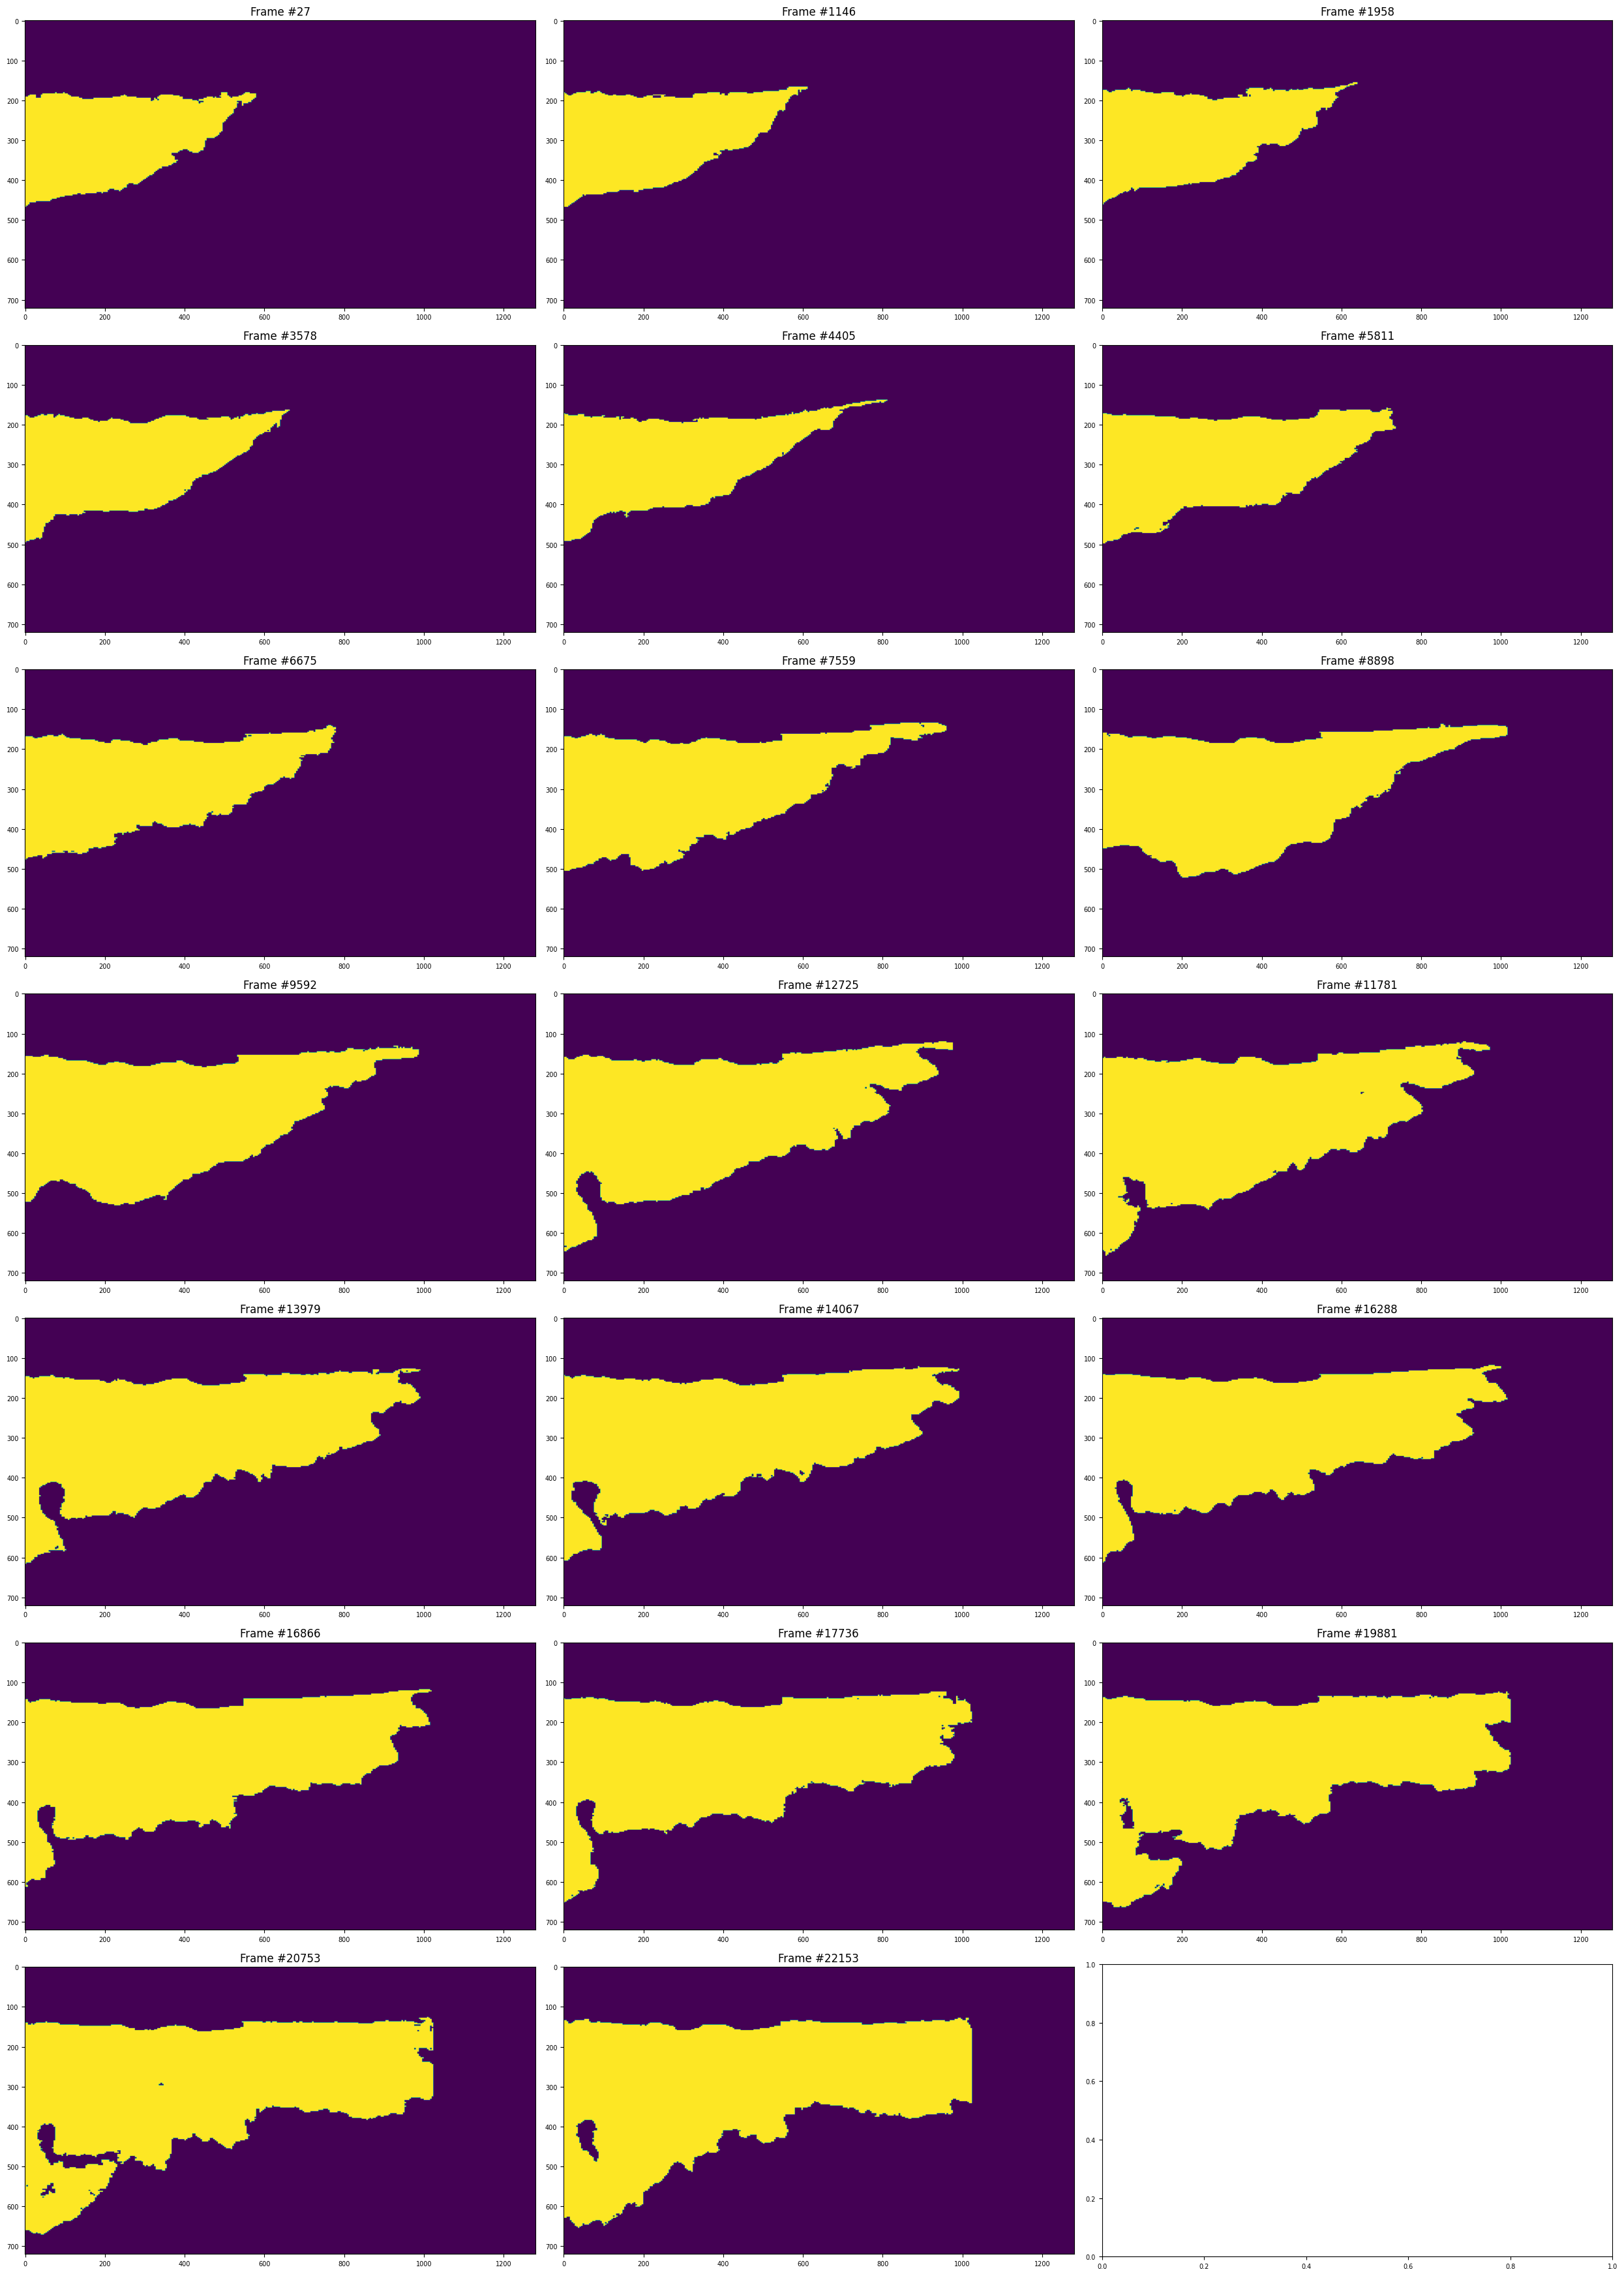

In [329]:
sampled_polygons = sample_polygons(polygons, distances, num_samples=20)
